# **African Health Burden Analysis**

- *The goal is to analyze the burden of diseases and injuries in Africa over time using the Global Burden of Disease (GBD) dataset, focusing on Disability-Adjusted Life Years (DALYs) and Mortality Trends across countries, age groups, sexes, and causes, and to use time series forecasting to predict future health outcomes.*

**Specific Objectives**

1. Describe current health patterns: Identify which diseases or causes contribute the most to DALYs and deaths across African countries.
2. Examine demographic differences: Compare trends by sex and age to highlight vulnerable populations.
3. Track changes over time: Explore how disease burden has evolved between 2003 and 2023 using visualizations and time series decomposition.
4. Forecast future trends: Apply statistical or machine learning methods (ARIMA) to predict future DALY and death patterns.

### 1. Setup and load main country-level DALY/death file

In [87]:
# 1. SETUP AND LOAD MAIN DATA
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Load main GBD file (country level, all ages, both sexes, all causes)
df = pd.read_csv("IHME-GBD_2023_DATA-b7fb5d99-1.csv")

print("Data shape:", df.shape)
print(df.columns)
print(df.head())

# Standardize measure names
df["measure"] = df["measure"].replace({
    "DALYs (Disability-Adjusted Life Years)": "DALYs"
})

print("Unique measures:", df["measure"].unique())
print("Unique locations:", df["location"].unique())


Data shape: (4515, 10)
Index(['measure', 'location', 'sex', 'age', 'cause', 'metric', 'year', 'val',
       'upper', 'lower'],
      dtype='object')
  measure      location   sex       age                           cause  \
0  Deaths      Ethiopia  Both  All ages         Cardiovascular diseases   
1  Deaths      Ethiopia  Both  All ages  Skin and subcutaneous diseases   
2  Deaths      Ethiopia  Both  All ages              Transport injuries   
3  Deaths      Ethiopia  Both  All ages          Unintentional injuries   
4  Deaths  South Africa  Both  All ages          Neurological disorders   

   metric  year           val         upper         lower  
0  Number  2003  46195.941115  58542.031037  35783.880680  
1  Number  2003   1184.893118   1966.990848    705.726816  
2  Number  2003  16423.494020  22913.278828  11275.884290  
3  Number  2003  29843.758926  38264.364250  21343.838597  
4  Number  2003   7074.403261  14988.294552   3316.796730  
Unique measures: ['Deaths' 'DALYs']
Uniq

--------------------------------
- The raw GBD 2003-2023 file contains 4,515 rows and 10 columns. Each row is a specific combination of country, sex, age group, cause and year, with a numeric estimate (val) and 95% uncertainty interval (lower, upper) for either Deaths or Disability-Adjusted Life Years (DALYs). The metric is always a simple count (Number).
- -----------------------------

### 2. Build country-year table: DALYs and Deaths (with bounds)

In [2]:
# 2. BUILD COUNTRY-YEAR TABLE (DALYs, Deaths, bounds) --------------------

# Pivot to have columns like:
# val_DALYs, val_Deaths, upper_DALYs, upper_Deaths, lower_DALYs, lower_Deaths
pivot_df = df.pivot_table(
    index=["year", "location", "sex", "age", "cause", "metric"],
    columns="measure",
    values=["val", "upper", "lower"]
).reset_index()

# Flatten multiindex columns
pivot_df.columns = [
    "_".join([part for part in col if part]).strip("_")
    for col in pivot_df.columns
]

print(pivot_df.head(2))
print(pivot_df.columns)

# Identify numeric measure columns
num_cols = [c for c in pivot_df.columns if c.startswith(("val_","upper_","lower_"))]

# Aggregate to: year x country totals across sex, age, cause
simple_df_total = (
    pivot_df
      .groupby(["year","location"], as_index=False)[num_cols]
      .sum()
)

print(simple_df_total.head())
print(simple_df_total.columns.tolist())
print(simple_df_total.info())
print(simple_df_total.describe())

# quick sanity check
print("Missing values:\n", simple_df_total.isna().sum())
print("Rows per year:\n", simple_df_total["year"].value_counts().sort_index())

   year location   sex       age                         cause  metric  \
0  2003    Egypt  Both  All ages       Cardiovascular diseases  Number   
1  2003    Egypt  Both  All ages  Chronic respiratory diseases  Number   

    lower_DALYs   lower_Deaths   upper_DALYs   upper_Deaths     val_DALYs  \
0  5.282248e+06  181561.986923  6.569209e+06  222705.398337  5.924582e+06   
1  4.697760e+05   10209.190214  7.603091e+05   18546.524640  6.052922e+05   

      val_Deaths  
0  201327.470155  
1   14165.509820  
Index(['year', 'location', 'sex', 'age', 'cause', 'metric', 'lower_DALYs',
       'lower_Deaths', 'upper_DALYs', 'upper_Deaths', 'val_DALYs',
       'val_Deaths'],
      dtype='object')
   year      location   lower_DALYs  lower_Deaths   upper_DALYs  upper_Deaths  \
0  2003         Egypt  2.032924e+07  3.822180e+05  3.064054e+07  5.442458e+05   
1  2003      Ethiopia  4.920891e+07  6.817706e+05  8.189544e+07  1.150046e+06   
2  2003         Kenya  1.767736e+07  2.622164e+05  2.599312

------------------------
- I collapsed the detailed table into an annual country-level panel with total DALYs and total deaths plus their uncertainty bounds. This gives 105 observations (5 countries × 21 years). Descriptives show very large burden overall (mean ≈ 53M DALYs and 0.8M deaths per country-year), with Nigeria consistently at the top.
-----

### 3. Country-level time trends and deaths–DALYs relationship

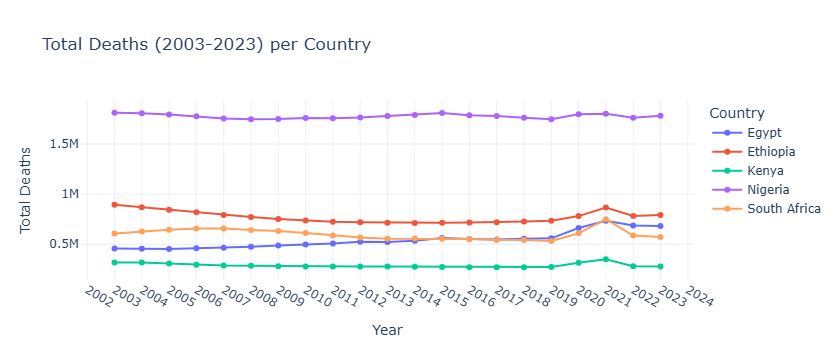

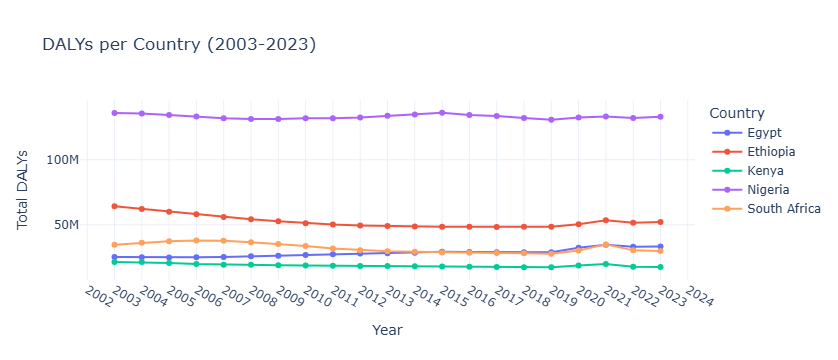

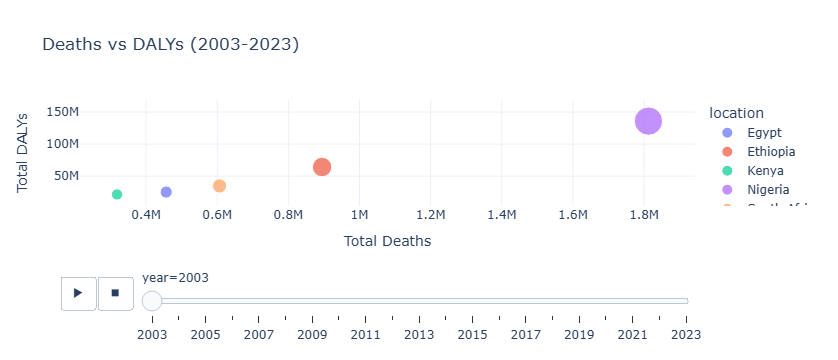

country  years   mean_dalys mean_deaths  pearson_r  pearson_p  \
0         Egypt      8   31,144,858     623,030     0.9978     0.0000   
1      Ethiopia      8   50,180,172     765,466     0.9670     0.0001   
2         Kenya      8   18,001,738     289,216     0.9893     0.0000   
3       Nigeria      8  132,670,654   1,777,710     0.7027     0.0519   
4  South Africa      8   29,760,943     586,253     0.9858     0.0000   

   slope_dalys_per_death     intercept      r2  mean_dalys_per_death  \
0                32.1599  1.110826e+07  0.9956               50.2228   
1                37.9022  2.116736e+07  0.9350               65.6558   
2                30.9855  9.040246e+06  0.9787               62.4870   
3                41.8456  5.828130e+07  0.4939               74.6332   
4                32.2759  1.083911e+07  0.9717               50.9650   

   std_dalys_per_death  
0               2.1890  
1               1.8332  
2               2.8515  
3               0.5551  
4               1.9832

In [3]:
# 3. COUNTRY-LEVEL TIME SERIES AND DEATHS–DALYs RELATIONSHIP ------------

# 3.1 Total deaths per country over time
fig = px.line(
    simple_df_total,
    x="year",
    y="val_Deaths",
    color="location",
    markers=True,
    title="Total Deaths (2003-2023) per Country",
    labels={"val_Deaths": "Total Deaths", "year": "Year", "location": "Country"},
)
fig.update_layout(
    hovermode="x unified",
    template="plotly_white",
    legend_title_text="Country"
)
fig.update_xaxes(dtick=1)
fig.show()

# 3.2 Total DALYs per country over time
fig = px.line(
    simple_df_total,
    x="year",
    y="val_DALYs",
    color="location",
    markers=True,
    title="DALYs per Country (2003-2023)",
    labels={"val_DALYs": "Total DALYs", "year": "Year", "location": "Country"},
)
fig.update_layout(hovermode="x unified", template="plotly_white")
fig.update_xaxes(dtick=1)
fig.show()

# 3.3 Animated scatter: Deaths vs DALYs by year
fig = px.scatter(
    simple_df_total,
    x="val_Deaths",
    y="val_DALYs",
    color="location",
    size="val_DALYs",
    animation_frame="year",
    title="Deaths vs DALYs (2003-2023)",
    labels={"val_Deaths": "Total Deaths", "val_DALYs": "Total DALYs"},
    hover_name="location"
)
fig.update_layout(template="plotly_white")
fig.show()

# 3.4 Country-wise linear relationship (2016-2023)
df_country = simple_df_total.copy()
df_country = df_country[
    (df_country["year"] >= 2016) & (df_country["year"] <= 2023)
].dropna(subset=["val_Deaths","val_DALYs"])

rows = []
for country, g in df_country.groupby("location"):
    X = g[["val_Deaths"]].values
    y = g["val_DALYs"].values

    if len(g) >= 3:
        r, p = pearsonr(g["val_Deaths"].values, g["val_DALYs"].values)
    else:
        r, p = np.nan, np.nan

    lr = LinearRegression()
    lr.fit(X, y)
    yhat = lr.predict(X)
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

    ratio = g["val_DALYs"] / g["val_Deaths"]

    rows.append({
        "country": country,
        "years": len(g),
        "mean_dalys": g["val_DALYs"].mean(),
        "mean_deaths": g["val_Deaths"].mean(),
        "pearson_r": r,
        "pearson_p": p,
        "slope_dalys_per_death": float(lr.coef_[0]),
        "intercept": float(lr.intercept_),
        "r2": r2,
        "mean_dalys_per_death": ratio.mean(),
        "std_dalys_per_death": ratio.std(ddof=1)
    })

country_report = pd.DataFrame(rows).sort_values("country").reset_index(drop=True)

def fmt_big(n):
    return f"{n:,.0f}"

report_pretty = country_report.copy()
report_pretty["mean_dalys"] = country_report["mean_dalys"].apply(fmt_big)
report_pretty["mean_deaths"] = country_report["mean_deaths"].apply(fmt_big)
report_pretty = report_pretty.round(4)
report_pretty

------------

- The line charts show that all countries experienced a gradual decline in deaths and DALYs from 2003 to around 2015, followed by a slight rebound or plateau after 2019. Nigeria carries the highest absolute burden throughout, while Kenya and Egypt have the lowest levels in this subset.

- The animated scatter confirms a very tight positive association between deaths and DALYs within each country over time. Correlations are extremely high (ρ ≈ 0.97–0.99 for Egypt, Ethiopia, Kenya and South Africa), meaning that years with more deaths also have more DALYs. Nigeria still shows a positive relationship but with more variability (ρ ≈ 0.70), suggesting additional noise or changing non-fatal burden there.

- DALYs per death are highest in Nigeria (≈ 75 DALYs per death) and Ethiopia (≈ 66), indicating a heavy combination of premature mortality and disability per fatal case in these settings. Kenya is slightly lower (~62), while Egypt and South Africa are around 50.
-----------

### 4. Additional country-level summaries

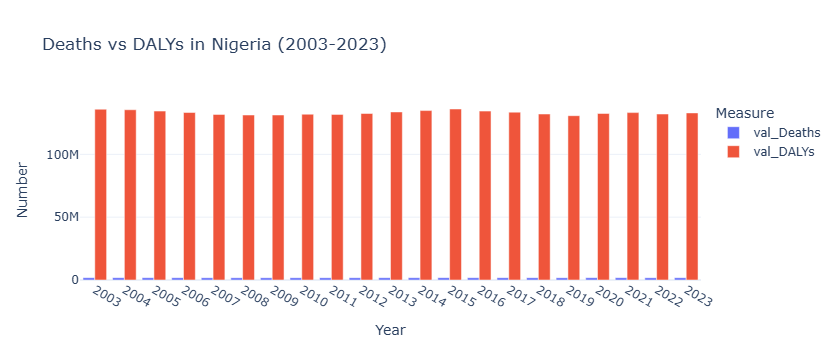

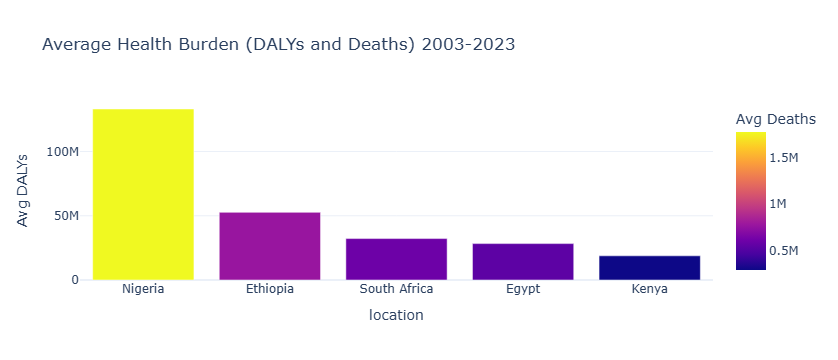

In [4]:
# 4. ADDITIONAL COUNTRY SUMMARIES ----------------------------------------

# 4.1 Example: Nigeria - bar chart DALYs vs Deaths over time
country = "Nigeria"
fig = px.bar(
    simple_df_total[simple_df_total["location"] == country],
    x="year",
    y=["val_Deaths", "val_DALYs"],
    barmode="group",
    title=f"Deaths vs DALYs in {country} (2003-2023)",
    labels={"value": "Number", "variable": "Measure", "year": "Year"}
)
fig.update_layout(template="plotly_white")
fig.update_xaxes(dtick=1)
fig.show()

# 4.2 Average burden across the whole period
avg_burden = (
    simple_df_total
    .groupby("location")[["val_Deaths", "val_DALYs"]]
    .mean()
    .sort_values("val_DALYs", ascending=False)
    .reset_index()
)

fig = px.bar(
    avg_burden,
    x="location",
    y="val_DALYs",
    color="val_Deaths",
    title="Average Health Burden (DALYs and Deaths) 2003-2023",
    labels={"val_DALYs": "Avg DALYs", "val_Deaths": "Avg Deaths"},
)
fig.update_layout(template="plotly_white")
fig.show()

------------
- The Nigeria bar chart illustrates that DALYs are much larger in scale than deaths every year, reflecting the years of life lost plus years lived with disability. The average burden plot highlights Nigeria as the clear outlier with the largest mean DALYs and deaths across the period.
- -----------

### 5. Cause-level analysis (top causes)

Number of unique causes: 22
Example causes: ['Cardiovascular diseases' 'Chronic respiratory diseases'
 'Diabetes and kidney diseases' 'Digestive diseases' 'Enteric infections'
 'HIV/AIDS and sexually transmitted infections'
 'Maternal and neonatal disorders' 'Mental disorders'
 'Musculoskeletal disorders' 'Neglected tropical diseases and malaria']
Top 5 causes by avg deaths: ['Cardiovascular diseases', 'Respiratory infections and tuberculosis', 'Maternal and neonatal disorders', 'HIV/AIDS and sexually transmitted infections', 'Enteric infections']


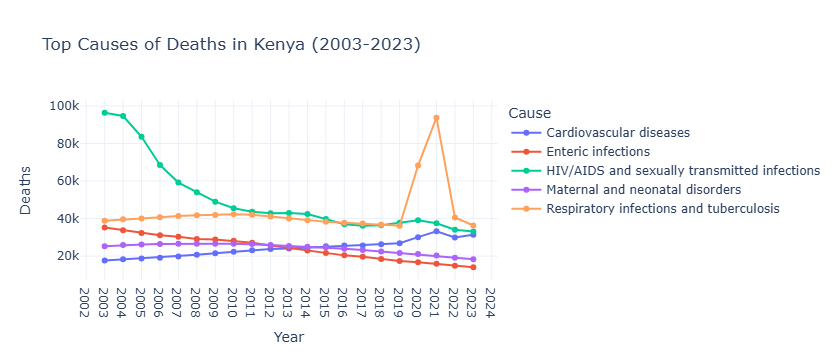

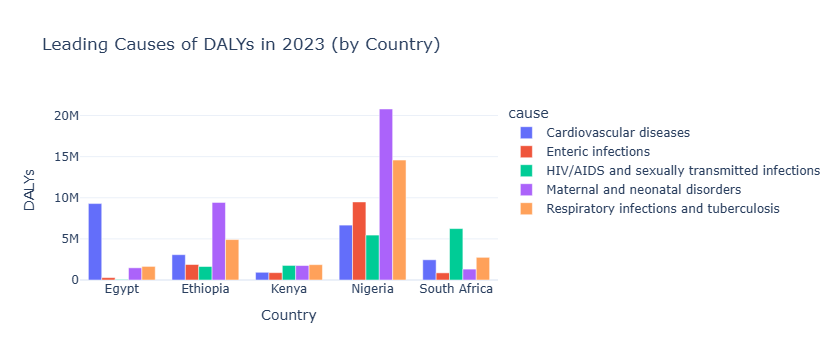

In [5]:
# 5. CAUSE-LEVEL ANALYSIS -----------------------------------------------

num_cols = [c for c in pivot_df.columns if c.startswith(("val_","upper_","lower_"))]

by_cause = (
    pivot_df
      .groupby(["year","location","cause"], as_index=False)[num_cols]
      .sum()
)

print("Number of unique causes:", by_cause["cause"].nunique())
print("Example causes:", by_cause["cause"].unique()[:10])

# Top 5 causes by average deaths
top_causes = (
    by_cause
    .groupby("cause")["val_Deaths"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
print("Top 5 causes by avg deaths:", top_causes)

by_cause_top = by_cause[by_cause["cause"].isin(top_causes)]

# Example: top causes of deaths in Kenya
country = "Kenya"
country_causes = by_cause_top[by_cause_top["location"] == country]

fig = px.line(
    country_causes,
    x="year",
    y="val_Deaths",
    color="cause",
    markers=True,
    title=f"Top Causes of Deaths in {country} (2003-2023)",
    labels={"val_Deaths": "Deaths", "year": "Year", "cause": "Cause"}
)
fig.update_layout(template="plotly_white")
fig.update_xaxes(dtick=1)
fig.show()

# Leading causes of DALYs in latest year
latest_year = by_cause_top["year"].max()
latest = by_cause_top[by_cause_top["year"] == latest_year]

fig = px.bar(
    latest,
    x="location",
    y="val_DALYs",
    color="cause",
    title=f"Leading Causes of DALYs in {latest_year} (by Country)",
    barmode="group",
    labels={"val_DALYs": "DALYs", "location": "Country"}
)
fig.update_layout(template="plotly_white")
fig.update_xaxes(dtick=1)
fig.show()

-----
- When I aggregate by cause, a small set of conditions drive most of the burden. Across countries, the top causes of death are cardiovascular disease, respiratory infections/TB, maternal–neonatal disorders, HIV/AIDS and enteric infections.

- In Kenya, the time-series shows a sharp decline in HIV/AIDS-related deaths since the early 2000s, while cardiovascular and respiratory causes become more prominent in later years.

- The 2023 DALY chart confirms that these same causes dominate non-fatal burden as well, with Nigeria showing especially high DALYs from HIV/AIDS/STIs and respiratory infections, and Ethiopia retaining a large contribution from maternal–neonatal conditions and infectious diseases.

--------

### 6. Age-structure analysis (second file: age + gender)

In [6]:
# 6. AGE-STRUCTURE ANALYSIS (AGE + GENDER FILE) -------------------------

df_new = pd.read_csv("IHME-GBD_2023_DATA-4e80f6ce-1_age_gender.csv")
print(df_new.head(10))
print(df_new.columns)

# Separate DALYs and Deaths
dalys_df = df_new[df_new["measure"].str.contains("DALY", case=False)]
deaths_df = df_new[df_new["measure"] == "Deaths"]

# Aggregate totals for each year, country, age
dalys_age = dalys_df.groupby(["year", "location", "age"], as_index=False)[["val", "upper", "lower"]].sum()
deaths_age = deaths_df.groupby(["year", "location", "age"], as_index=False)[["val", "upper", "lower"]].sum()

# Rename
dalys_age = dalys_age.rename(columns={"val": "val_DALYs", "upper": "upper_DALYs", "lower": "lower_DALYs"})
deaths_age = deaths_age.rename(columns={"val": "val_Deaths", "upper": "upper_Deaths", "lower": "lower_Deaths"})

# Merge
by_age = pd.merge(dalys_age, deaths_age, on=["year", "location", "age"], how="outer")
print(sorted(by_age["age"].unique()))

  measure location     sex          age  \
0  Deaths  Nigeria    Male     <5 years   
1  Deaths  Nigeria  Female     <5 years   
2  Deaths  Nigeria    Male     0-6 days   
3  Deaths  Nigeria  Female     0-6 days   
4  Deaths  Nigeria    Male    7-27 days   
5  Deaths  Nigeria  Female    7-27 days   
6  Deaths  Nigeria    Male    5-9 years   
7  Deaths  Nigeria  Female    5-9 years   
8  Deaths  Nigeria    Male  10-14 years   
9  Deaths  Nigeria  Female  10-14 years   

                                               cause  metric  year  \
0  Communicable, maternal, neonatal, and nutritio...  Number  2003   
1  Communicable, maternal, neonatal, and nutritio...  Number  2003   
2  Communicable, maternal, neonatal, and nutritio...  Number  2003   
3  Communicable, maternal, neonatal, and nutritio...  Number  2003   
4  Communicable, maternal, neonatal, and nutritio...  Number  2003   
5  Communicable, maternal, neonatal, and nutritio...  Number  2003   
6  Communicable, maternal, neonatal,

----
- The age–gender file adds a finer breakdown by sex and age group. It splits the burden into neonatal periods (0–6 days, 7–27 days), monthly groups in the first year of life, multiple child and adolescent bands, adult 5-year bands, and broad summary categories like <5 years or 70+ years. This richness is useful but makes direct visualisation messy, so I later collapsed these into a smaller set of intuitive age groups.
- ----

### 7. Simplified age groups + age composition of DALYs

age_group_simplified
Elderly (70+ yrs)           1155
Adults (25-54 yrs)           840
Older Adults (55-69 yrs)     630
Children (5-14 yrs)          420
Infants (<1 yr)              420
Youth (15-24 yrs)            420
Neonates                     315
Children (1-4 yrs)           210
Name: count, dtype: int64


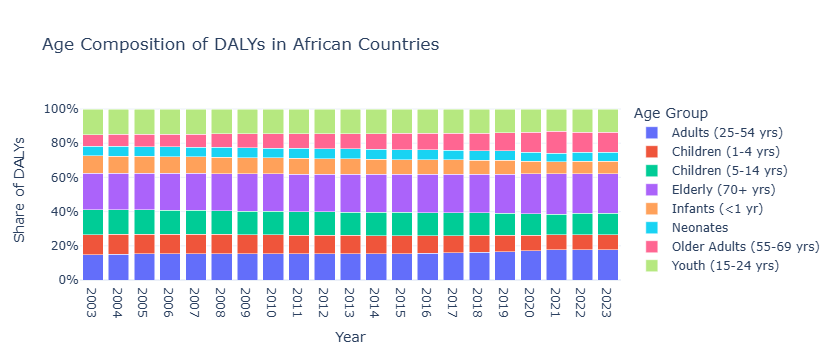

In [7]:
# 7. SIMPLIFY AGE GROUPS AND PLOT COMPOSITION ---------------------------

def simplify_age(age):
    if age in ["0-6 days","7-27 days","<28 days"]:
        return "Neonates"
    elif age in ["1-5 months","6-11 months","<1 year","12-23 months"]:
        return "Infants (<1 yr)"
    elif age in ["2-4 years","<5 years"]:
        return "Children (1-4 yrs)"
    elif age in ["5-9 years","10-14 years","0-14 years","5-14 years"]:
        return "Children (5-14 yrs)"
    elif age in ["15-19 years","20-24 years","10-19 years","<20 years"]:
        return "Youth (15-24 yrs)"
    elif age in ["25-29 years","30-34 years","35-39 years","40-44 years","45-49 years",
                 "50-54 years","15-49 years","20-54 years"]:
        return "Adults (25-54 yrs)"
    elif age in ["55-59 years","60-64 years","65-69 years","50-69 years","50-74 years","55+ years"]:
        return "Older Adults (55-69 yrs)"
    elif age in ["70-74 years","75+ years","80+ years","85+ years","90-94 years",
                 "95+ years","70+ years","65-74 years","75-84 years","85-89 years","<70 years"]:
        return "Elderly (70+ yrs)"

by_age["age_group_simplified"] = by_age["age"].apply(simplify_age)
print(by_age["age_group_simplified"].value_counts())

by_age_simplified = (
    by_age.groupby(["year","location","age_group_simplified"], as_index=False)[["val_DALYs","val_Deaths"]].sum()
)

# Age composition of DALYs across Africa over time (100% stacked bar)
tot = (
    by_age_simplified
    .groupby(["year","age_group_simplified"], as_index=False)["val_DALYs"]
    .sum()
)
tot["year_total"] = tot.groupby("year")["val_DALYs"].transform("sum")
tot["share"] = tot["val_DALYs"] / tot["year_total"]

fig = px.bar(
    tot.sort_values("year"),
    x="year", y="share", color="age_group_simplified",
    title="Age Composition of DALYs in African Countries",
    labels={"share":"Share of DALYs","year":"Year","age_group_simplified":"Age Group"},
)
fig.update_layout(template="plotly_white", barmode="stack", hovermode="x unified", legend_title="Age Group")
fig.update_xaxes(dtick=1)
fig.update_yaxes(tickformat=".0%")
fig.show()

- Collapsing the original ~50 age bands into 8 life-stage groups gives a much clearer picture. Adults 25–54 years account for the largest share of DALYs every year, followed by children 5–14 and the elderly (70+). The 100% stacked bars show that, over time, the relative share of DALYs is slowly shifting towards older age groups, consistent with population ageing and epidemiological transition.

### 8. Extra age-focused visuals (examples)

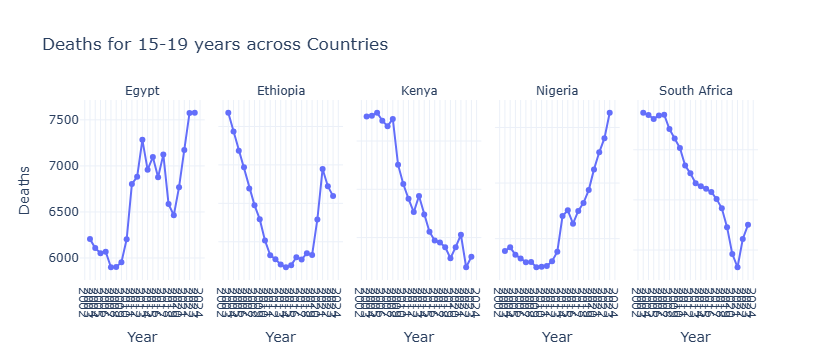

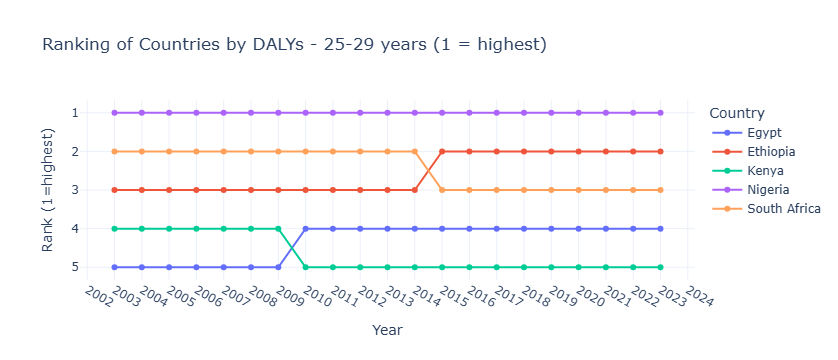

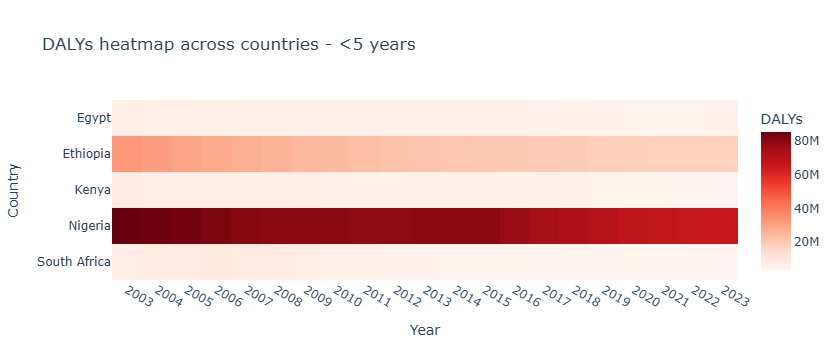

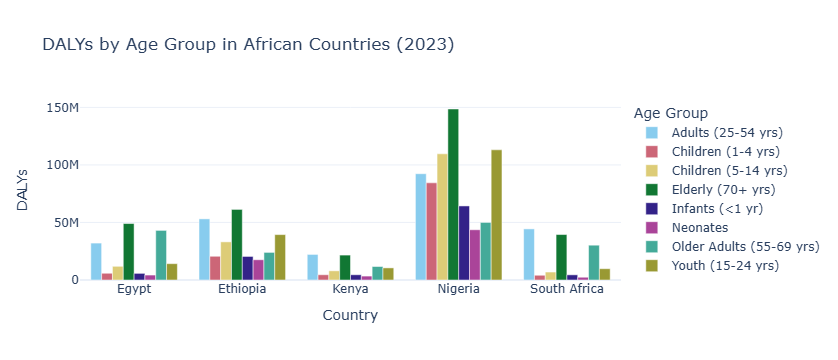

In [8]:
# 8. EXTRA AGE-FOCUSED VISUALS ------------------------------------------

# 8.1 Deaths for a specific age across countries (facets)
age_focus = "15-19 years"
focus_df = (by_age[by_age["age"] == age_focus]
            .groupby(["year","location"], as_index=False)["val_Deaths"].sum())

fig = px.line(
    focus_df, x="year", y="val_Deaths",
    facet_col="location", facet_col_wrap=5,
    markers=True,
    title=f"Deaths for {age_focus} across Countries",
    labels={"val_Deaths":"Deaths","year":"Year"}
)
fig.update_traces(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(template="plotly_white", hovermode="x unified")
fig.update_xaxes(dtick=1)
fig.update_yaxes(matches=None, showgrid=True)
fig.show()

# 8.2 Ranking countries by DALYs for one age group
age_focus = "25-29 years"
focus_df = (by_age[by_age["age"] == age_focus]
            .groupby(["year","location"], as_index=False)["val_DALYs"].sum())
focus_df["rank"] = focus_df.groupby("year")["val_DALYs"].rank(ascending=False, method="dense")

fig = px.line(
    focus_df, x="year", y="rank", color="location", markers=True,
    title=f"Ranking of Countries by DALYs - {age_focus} (1 = highest)",
    labels={"rank":"Rank (1=highest)", "year":"Year", "location":"Country"}
)
fig.update_yaxes(autorange="reversed", dtick=1)
fig.update_xaxes(dtick=1)
fig.update_layout(template="plotly_white", hovermode="x unified")
fig.show()

# 8.3 Heatmap for <5 years
age_focus = "<5 years"
hm = (by_age[by_age["age"] == age_focus]
      .groupby(["location","year"], as_index=False)["val_DALYs"].sum())

mat = hm.pivot(index="location", columns="year", values="val_DALYs")

fig = px.imshow(
    mat,
    color_continuous_scale="Reds",
    aspect="auto",
    labels=dict(x="Year", y="Country", color="DALYs"),
    title=f"DALYs heatmap across countries - {age_focus}"
)
fig.update_layout(template="plotly_white")
fig.update_xaxes(dtick=1)
fig.show()

# 8.4 Latest-year age profile by country
latest_year = by_age_simplified["year"].max()
latest_df = by_age_simplified[by_age_simplified["year"] == latest_year]

fig = px.bar(
    latest_df,
    x="location", y="val_DALYs",
    color="age_group_simplified",
    barmode="group",
    title=f"DALYs by Age Group in African Countries ({latest_year})",
    labels={"val_DALYs": "DALYs", "location": "Country", "age_group_simplified": "Age Group"},
    color_discrete_sequence=px.colors.qualitative.Safe
)
fig.update_layout(template="plotly_white", title_x=0.05)
fig.show()

- Age-specific views reveal important differences between countries. For example, in the 25–29 year group, Nigeria ranks first almost every year, while Kenya and Egypt remain at the bottom. The <5 years heatmap shows persistently very high DALYs in Nigeria and Ethiopia, meaning that early-childhood conditions remain a critical issue there.

- In 2023, the age-group bar chart confirms a double focus for policy: high DALYs in working-age adults (economic impact) and in under-5 children (preventable early-life illness and mortality).

### 9. Sex/gender analysis (DALYs and ratios)

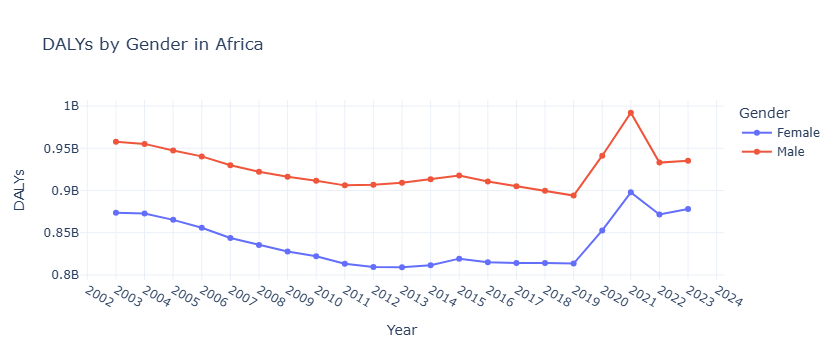

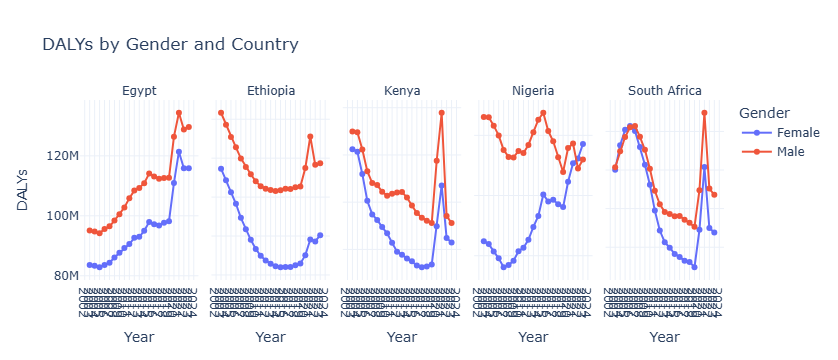

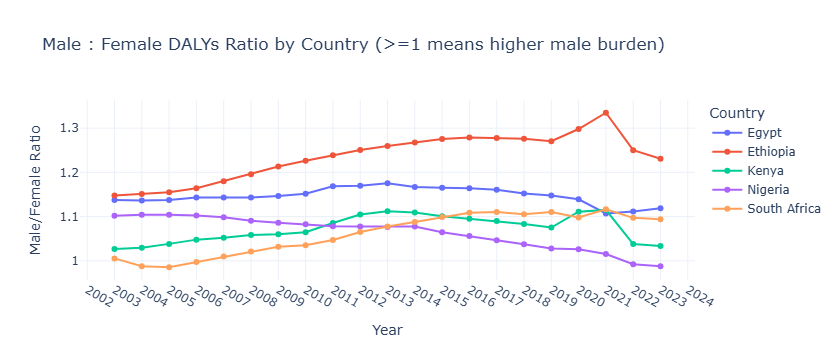

In [9]:
# 9. SEX/GENDER ANALYSIS -----------------------------------------------

df_fix = df_new.copy()
df_fix["measure"] = df_fix["measure"].replace(
    {"DALYs (Disability-Adjusted Life Years)": "DALYs"}
)

# DALYs by sex
dalys_sex = (
    df_fix[df_fix["measure"] == "DALYs"]
    .groupby(["year","location","sex"], as_index=False)[["val","upper","lower"]]
    .sum()
    .rename(columns={"val":"val_DALYs","upper":"upper_DALYs","lower":"lower_DALYs"})
)

# Deaths by sex
deaths_sex = (
    df_fix[df_fix["measure"] == "Deaths"]
    .groupby(["year","location","sex"], as_index=False)[["val","upper","lower"]]
    .sum()
    .rename(columns={"val":"val_Deaths","upper":"upper_Deaths","lower":"lower_Deaths"})
)

# Merge
by_sex = pd.merge(dalys_sex, deaths_sex, on=["year","location","sex"], how="outer")
by_sex["year"] = by_sex["year"].astype(int)

# 9.1 DALYs by sex across Africa
by_sex_total = (
    by_sex.groupby(["year","sex"], as_index=False)["val_DALYs"].sum()
)

fig = px.line(
    by_sex_total,
    x="year", y="val_DALYs", color="sex",
    markers=True,
    title="DALYs by Gender in Africa",
    labels={"val_DALYs":"DALYs","year":"Year","sex":"Gender"},
)
fig.update_layout(template="plotly_white", hovermode="x unified", title_x=0.05)
fig.update_xaxes(dtick=1)
fig.show()

# 9.2 DALYs by sex and country (faceted)
fig = px.line(
    by_sex,
    x="year", y="val_DALYs",
    color="sex",
    facet_col="location", facet_col_wrap=5,
    markers=True,
    title="DALYs by Gender and Country",
    labels={"val_DALYs":"DALYs","year":"Year","sex":"Gender"},
)
fig.update_layout(template="plotly_white", hovermode="x unified", title_x=0.05)
fig.update_xaxes(dtick=1)
fig.update_yaxes(matches=None, showgrid=True)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

# 9.3 Male/Female DALYs ratio
ratio_df = (
    by_sex.pivot_table(index=["year","location"], columns="sex", values="val_DALYs")
          .reset_index()
)

ratio_df = ratio_df.dropna(subset=["Male","Female"], how="any").copy()
ratio_df["M_F_Ratio"] = ratio_df["Male"] / ratio_df["Female"]

fig = px.line(
    ratio_df,
    x="year", y="M_F_Ratio", color="location",
    markers=True,
    title="Male : Female DALYs Ratio by Country (>=1 means higher male burden)",
    labels={"M_F_Ratio":"Male/Female Ratio","year":"Year","location":"Country"},
)
fig.update_layout(template="plotly_white", hovermode="x unified", title_x=0.05)
fig.update_xaxes(dtick=1)
fig.update_yaxes(zeroline=True)
fig.show()

- Aggregating by sex shows that males consistently have a higher DALY burden than females in all five countries, but the gap varies. At the continental level, the male DALY curve lies above the female curve throughout 2003–2023, with a visible spike around 2020–2021 likely linked to COVID-19 and related disruptions.

- Country-level facets show that the male excess is particularly pronounced in Nigeria and South Africa, where male DALYs rise more steeply in recent years. The Male:Female ratio plot confirms this: South Africa and Nigeria reach ratios above 1.2, meaning male burden is at least 20% higher than female. Egypt, Ethiopia and Kenya show smaller gender gaps (ratios close to 1.0–1.1). This suggests that male-targeted prevention (injuries, occupational and behavioural risks) may be especially important in Nigeria and South Africa.

### 10. Cause × gender analysis (third file)

  measure location     sex       age                                    cause  \
0  Deaths  Nigeria    Male  All ages  Neglected tropical diseases and malaria   
1  Deaths  Nigeria  Female  All ages  Neglected tropical diseases and malaria   
2  Deaths  Nigeria    Male  All ages                 Nutritional deficiencies   
3  Deaths  Nigeria  Female  All ages                 Nutritional deficiencies   
4  Deaths  Nigeria    Male  All ages                       Digestive diseases   
5  Deaths  Nigeria  Female  All ages                       Digestive diseases   
6  Deaths  Nigeria    Male  All ages                                Neoplasms   
7  Deaths  Nigeria  Female  All ages                                Neoplasms   
8  Deaths  Nigeria    Male  All ages                         Mental disorders   
9  Deaths  Nigeria  Female  All ages                         Mental disorders   

   metric  year            val          upper         lower  
0  Number  2003  124047.816780  186716.175807 

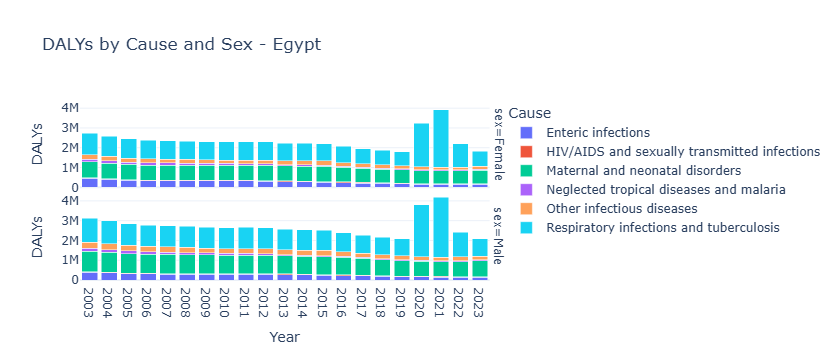

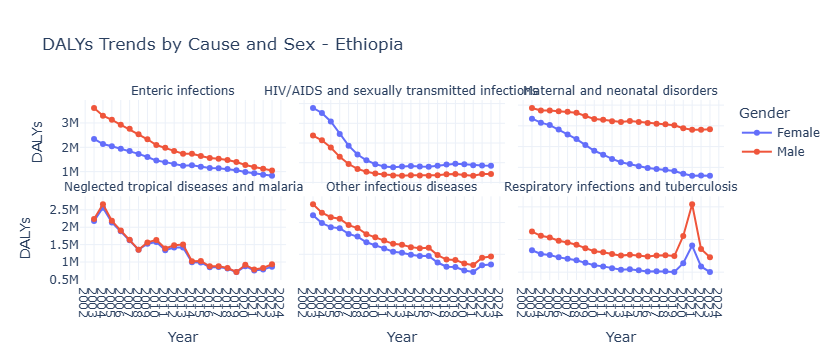

In [10]:
# 10. CAUSE × GENDER ANALYSIS -------------------------------------------

df_cg = pd.read_csv("IHME-GBD_2023_DATA-b1520254-1_cause_.csv")
df_cg["measure"] = df_cg["measure"].replace({"DALYs (Disability-Adjusted Life Years)": "DALYs"})

TARGET = "DALYs"

by_cause_sex = (
    df_cg[df_cg["measure"] == TARGET]
    .groupby(["year","location","sex","cause"], as_index=False)[["val","upper","lower"]]
    .sum()
    .rename(columns={"val": f"val_{TARGET}", "upper": f"upper_{TARGET}", "lower": f"lower_{TARGET}"})
)

print(df_cg.head(10))

# Top 6 causes overall
top_causes = (
    by_cause_sex.groupby("cause")[f"val_{TARGET}"].sum()
    .sort_values(ascending=False).head(6).index.tolist()
)
subset = by_cause_sex[by_cause_sex["cause"].isin(top_causes)].copy()

countries = sorted(subset["location"].unique())
default_country = countries[0]

fig = px.bar(
    subset[subset["location"]==default_country],
    x="year", y=f"val_{TARGET}",
    color="cause",
    facet_row="sex",
    barmode="stack",
    title=f"{TARGET} by Cause and Sex - {default_country}",
    labels={f"val_{TARGET}": TARGET, "year": "Year", "cause": "Cause"},
)

fig.update_layout(template="plotly_white", title_x=0.05, hovermode="x unified")
fig.update_xaxes(dtick=1)
fig.show()

# Example detailed trends for Ethiopia
country = "Ethiopia"
cgrid = (
    subset[subset["location"]==country]
    .groupby(["year","sex","cause"], as_index=False)[f"val_{TARGET}"].sum()
)

fig = px.line(
    cgrid, x="year", y=f"val_{TARGET}",
    color="sex",
    facet_col="cause", facet_col_wrap=3,
    markers=True,
    title=f"{TARGET} Trends by Cause and Sex - {country}",
    labels={f"val_{TARGET}": TARGET, "year":"Year", "sex":"Gender"}
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_traces(mode="lines+markers")
fig.update_layout(template="plotly_white", hovermode="x unified", title_x=0.05, legend_title_text="Gender")
fig.update_xaxes(dtick=1)
fig.update_yaxes(matches=None, showgrid=True)
fig.show()

- Breaking DALYs down jointly by cause and sex shows which conditions drive the gender gap. In Egypt, respiratory infections/TB and other infectious diseases dominate DALYs for both sexes, with similar patterns over time; the stacked bars show that the overall scale is slightly higher for males but the composition of causes is comparable.

- In Ethiopia, the faceted line plots reveal stronger declines over time for communicable causes such as HIV/AIDS, enteric infections and maternal–neonatal disorders. For several causes (e.g. road injuries and respiratory infections) male DALYs remain higher than female DALYs across the period, reflecting gendered risk exposures (work, mobility, behaviours).

### 11. Time series prep and ARIMA forecasting (per country)

measure  year location     val_DALYs    val_Deaths
0        2003    Egypt  1.786663e+08  3.522908e+06
1        2004    Egypt  1.781299e+08  3.522390e+06
2        2005    Egypt  1.770487e+08  3.500799e+06
3        2006    Egypt  1.791571e+08  3.563278e+06
4        2007    Egypt  1.808550e+08  3.608550e+06
['year', 'location', 'val_DALYs', 'val_Deaths']


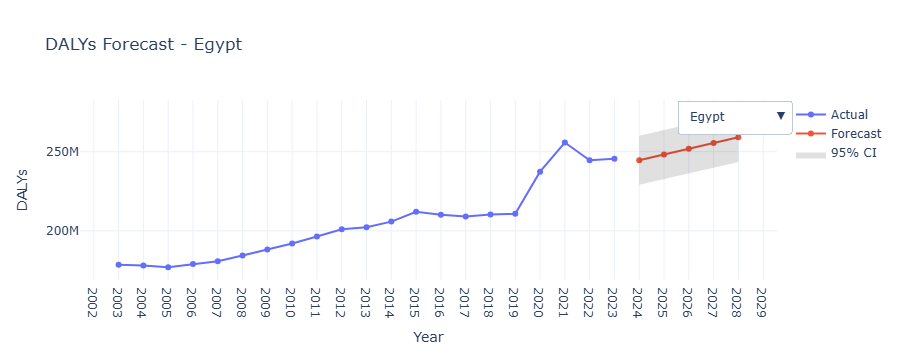

In [11]:
# 11. TIME SERIES FORECASTING WITH ARIMA (PER COUNTRY)
# ----------------------------------------------------
# Goal:
# - Build a simple country level DALYs or Deaths time series from the
#   age-gender file (df_new).
# - Fit an ARIMA model (with safe fallbacks) for each country.
# - Produce 5 year ahead forecasts with confidence intervals.
# - Provide an interactive plot with a country dropdown.

import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import plotly.graph_objects as go

# 11.1 - Rebuild simple_df_total from df_new in wide form
df_fix = df_new.copy()
df_fix["measure"] = df_fix["measure"].replace(
    {"DALYs (Disability-Adjusted Life Years)": "DALYs"}
)

agg = (
    df_fix.groupby(["year","location","measure"], as_index=False)["val"]
          .sum()
)

simple_df_total = (
    agg.pivot(index=["year","location"], columns="measure", values="val")
       .reset_index()
       .rename(columns={"DALYs":"val_DALYs", "Deaths":"val_Deaths"})
)

# ensure numeric types and sorting
simple_df_total["year"] = pd.to_numeric(simple_df_total["year"], errors="coerce")
for c in ["val_DALYs","val_Deaths"]:
    if c in simple_df_total.columns:
        simple_df_total[c] = pd.to_numeric(simple_df_total[c], errors="coerce")

simple_df_total = simple_df_total.sort_values(["location","year"]).reset_index(drop=True)

# choose target metric
if "val_DALYs" in simple_df_total.columns:
    TARGET = "val_DALYs"
elif "val_Deaths" in simple_df_total.columns:
    TARGET = "val_Deaths"
else:
    raise RuntimeError("Neither val_DALYs nor val_Deaths is present.")

print(simple_df_total.head())
print(simple_df_total.columns.tolist())

# 11.2 - Helper to fit ARIMA with several fallbacks
HORIZON = 5   # forecast 5 years ahead

def fit_arima_with_fallback(y, horizon=5):
    """
    Try a small set of ARIMA orders. If they all fail, fall back to
    a simple linear trend. If that fails, use a flat forecast.
    """
    y = pd.Series(y, dtype="float64").dropna()
    n = len(y)

    if n < 6:
        last = float(y.iloc[-1]) if n else 0.0
        pred = np.full(horizon, last)
        return pred, pred*0.9, pred*1.1

    # try several simple ARIMA structures
    for order in [(1,1,1), (0,1,1), (1,1,0), (0,1,0)]:
        try:
            m = ARIMA(
                y.values,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fit = m.fit()
            fc = fit.get_forecast(steps=horizon)
            pred = fc.predicted_mean.to_numpy()
            conf = fc.conf_int(alpha=0.05)
            lower = conf.iloc[:,0].to_numpy()
            upper = conf.iloc[:,1].to_numpy()
            return pred, lower, upper
        except Exception:
            continue

    # linear trend fallback
    x = np.arange(n)
    try:
        b1, b0 = np.polyfit(x, y.values, 1)
        x_f = np.arange(n, n+horizon)
        pred = b1 * x_f + b0
        resid = y.values - (b1 * x + b0)
        s = np.std(resid) if len(resid) > 1 else 0.1*(abs(y.iloc[-1])+1)
        lower = pred - 1.96*s
        upper = pred + 1.96*s
        return pred, lower, upper
    except Exception:
        last = float(y.iloc[-1])
        pred = np.full(horizon, last)
        return pred, pred*0.9, pred*1.1

# 11.3 - Fit models for all countries
df_ts = simple_df_total.dropna(subset=["year", TARGET]).copy()
df_ts["year"] = df_ts["year"].astype(int)
df_ts = df_ts.sort_values(["location","year"])

countries = df_ts["location"].unique()
forecast_results = []
issues = []

for country in countries:
    sub = df_ts[df_ts["location"] == country].sort_values("year")
    y = sub[TARGET].to_numpy()
    years = sub["year"].to_numpy()

    try:
        pred, lower, upper = fit_arima_with_fallback(y, horizon=HORIZON)
        future_years = np.arange(int(years[-1])+1, int(years[-1])+1+HORIZON)
        f = pd.DataFrame({
            "location": country,
            "year": future_years,
            "forecast": pred,
            "lower": lower,
            "upper": upper,
            "target": TARGET
        })
        forecast_results.append(f)
    except Exception as e:
        issues.append((country, str(e)))

if not forecast_results:
    raise RuntimeError(f"No forecasts produced. Issues: {issues}")

forecast_df = pd.concat(forecast_results, ignore_index=True)

# 11.4 - Interactive plot with country dropdown
def make_country_forecast_fig(country):
    actual = df_ts[df_ts["location"]==country].sort_values("year")
    pred = forecast_df[forecast_df["location"]==country].sort_values("year")
    label = "DALYs" if TARGET=="val_DALYs" else "Deaths"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=actual["year"], y=actual[TARGET],
        mode="lines+markers", name="Actual"
    ))
    fig.add_trace(go.Scatter(
        x=pred["year"], y=pred["forecast"],
        mode="lines+markers", name="Forecast"
    ))
    fig.add_trace(go.Scatter(
        x=pd.concat([pred["year"], pred["year"][::-1]]),
        y=pd.concat([pred["upper"], pred["lower"][::-1]]),
        fill="toself",
        fillcolor="rgba(0,0,0,0.12)",
        line=dict(color="rgba(0,0,0,0)"),
        name="95% CI"
    ))
    fig.update_layout(
        title=f"{label} Forecast - {country}",
        xaxis_title="Year",
        yaxis_title=label,
        template="plotly_white",
        hovermode="x unified"
    )
    fig.update_xaxes(dtick=1)
    return fig

default_country = countries[0]
fig = make_country_forecast_fig(default_country)

buttons = []
for c in countries:
    a = df_ts[df_ts["location"]==c].sort_values("year")
    p = forecast_df[forecast_df["location"]==c].sort_values("year")
    buttons.append(dict(
        label=c,
        method="update",
        args=[
            {
                "x":[a["year"], p["year"], pd.concat([p["year"], p["year"][::-1]])],
                "y":[a[TARGET], p["forecast"], pd.concat([p["upper"], p["lower"][::-1]])],
            },
            {"title": f"{'DALYs' if TARGET=='val_DALYs' else 'Deaths'} Forecast - {c}"}
        ]
    ))

fig.update_layout(
    updatemenus=[dict(buttons=buttons, direction="down", x=1.02, y=1.0, showactive=True)]
)
fig.show()

### 12. Spatial choropleth map (DALYs or deaths)

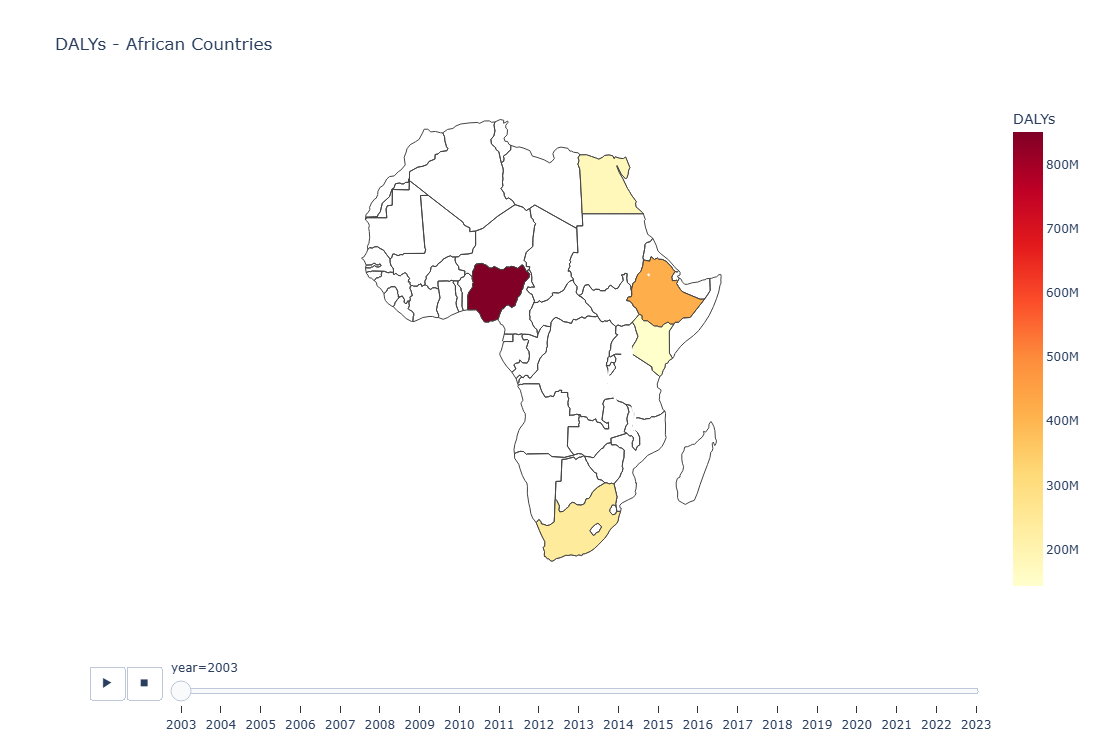

In [88]:
# 12. SPATIAL PATTERN - CHOROPLETH MAP
# ------------------------------------
# Goal:
# - Map DALYs or Deaths per country on an Africa map.
# - Use an animated choropleth to see how the burden moves over time.

iso3 = {
    "Ethiopia":"ETH", "Kenya":"KEN", "Tanzania":"TZA", "Uganda":"UGA", "Rwanda":"RWA",
    "Nigeria":"NGA", "DRC":"COD", "South Africa":"ZAF", "Egypt":"EGY", "Ghana":"GHA"
}

df_map = simple_df_total.copy()
df_map["iso3"] = df_map["location"].map(iso3)
df_map = df_map.dropna(subset=["iso3"]).copy()

METRIC = "val_DALYs"   # change to "val_Deaths" if needed
metric_label = "DALYs" if METRIC=="val_DALYs" else "Deaths"

fig = px.choropleth(
    df_map,
    locations="iso3",
    color=METRIC,
    hover_name="location",
    animation_frame="year",
    color_continuous_scale="YlOrRd",
    projection="natural earth",
    scope="africa",
    title=f"{metric_label} - African Countries",
    height=750,
    width=1200
)
fig.update_layout(
    template="plotly_white",
    coloraxis_colorbar_title=metric_label
)
fig.show()

### 13. Decomposition and anomaly detection (STL + residuals)

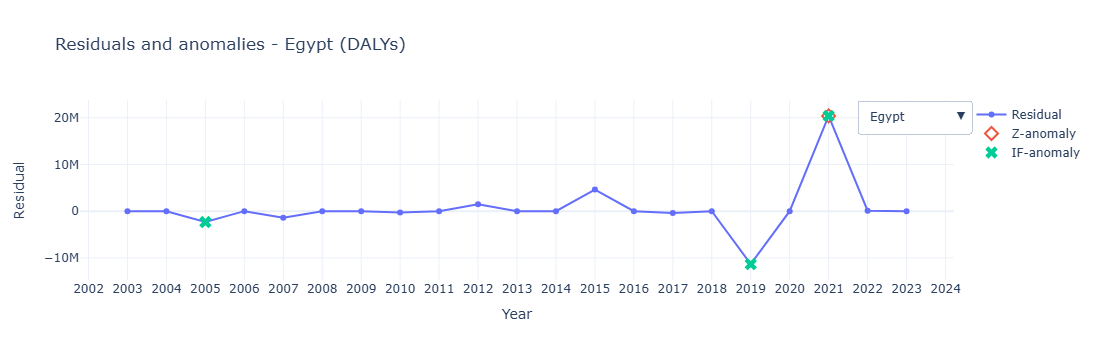

In [81]:
# 13. TREND DECOMPOSITION AND ANOMALY DETECTION
# ---------------------------------------------
# Goal:
# - Decompose each country time series (DALYs) into trend and residual.
# - Use STL to get a smooth trend.
# - Flag unusual years using z scores and Isolation Forest.

from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = simple_df_total.copy()
TARGET = "val_DALYs"   # or "val_Deaths"

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce")
df = df.dropna(subset=["year", TARGET]).sort_values(["location","year"])

decomp_frames = []

for c in df["location"].unique():
    sub = df[df["location"] == c][["year", TARGET]].copy()
    if len(sub) < 7:
        continue

    sub["date"] = pd.to_datetime(sub["year"].astype(int), format="%Y")
    sub = sub.sort_values("date").set_index("date")

    stl = STL(sub[TARGET], period=2, robust=True)
    res = stl.fit()

    out = pd.DataFrame({
        "location": c,
        "year": sub.index.year,
        "observed": sub[TARGET].values,
        "trend": res.trend,
        "seasonal": res.seasonal,
        "resid": res.resid
    })
    decomp_frames.append(out)

decomp = pd.concat(decomp_frames, ignore_index=True)

# z score of residuals per country
decomp["resid_mean"] = decomp.groupby("location")["resid"].transform("mean")
decomp["resid_std"]  = decomp.groupby("location")["resid"].transform("std").replace(0, np.nan)
decomp["zscore"] = (decomp["resid"] - decomp["resid_mean"]) / decomp["resid_std"]

Z_THRESH = 2.5
decomp["anomaly_z"] = decomp["zscore"].abs() > Z_THRESH

# Isolation Forest anomaly flags
def iforest_flags(group):
    X = pd.DataFrame({
        "resid": group["resid"].values,
        "t": np.arange(len(group))
    })
    if len(X) < 8:
        group["anomaly_if"] = False
        return group
    clf = IsolationForest(contamination=0.15, random_state=42)
    group["anomaly_if"] = clf.fit_predict(X) == -1
    return group

decomp = decomp.groupby("location", group_keys=False).apply(iforest_flags)

decomp_out = decomp[[
    "location","year","observed","trend","seasonal",
    "resid","zscore","anomaly_z","anomaly_if"
]]

countries = decomp_out["location"].unique().tolist()
default_c = countries[0]

def make_resid_fig(country):
    sub = decomp_out[decomp_out["location"]==country].sort_values("year")
    anom = sub[sub["anomaly_z"]]
    anom_if = sub[sub["anomaly_if"]]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=sub["year"], y=sub["resid"],
        mode="lines+markers", name="Residual"
    ))
    fig.add_trace(go.Scatter(
        x=anom["year"], y=anom["resid"],
        mode="markers", name="Z-anomaly",
        marker=dict(size=10, symbol="diamond-open", line=dict(width=2))
    ))
    fig.add_trace(go.Scatter(
        x=anom_if["year"], y=anom_if["resid"],
        mode="markers", name="IF-anomaly",
        marker=dict(size=11, symbol="x")
    ))
    fig.update_layout(
        title=f"Residuals and anomalies - {country} ({'DALYs' if TARGET=='val_DALYs' else 'Deaths'})",
        xaxis_title="Year",
        yaxis_title="Residual",
        template="plotly_white",
        hovermode="x unified"
    )
    fig.update_xaxes(dtick=1)
    return fig

fig = make_resid_fig(default_c)

buttons = []
for c in countries:
    sub = decomp_out[decomp_out["location"]==c].sort_values("year")
    anom = sub[sub["anomaly_z"]]
    anom_if = sub[sub["anomaly_if"]]

    buttons.append(dict(
        label=c,
        method="update",
        args=[
            {"x":[sub["year"], anom["year"], anom_if["year"]],
             "y":[sub["resid"], anom["resid"], anom_if["resid"]]},
            {"title": f"Residuals and anomalies - {c} ({'DALYs' if TARGET=='val_DALYs' else 'Deaths'})"}
        ]
    ))

fig.update_layout(updatemenus=[dict(buttons=buttons, x=1.02, y=1, showactive=True, direction="down")])
fig.show()

### 14. Spatial autocorrelation and temporal clusters

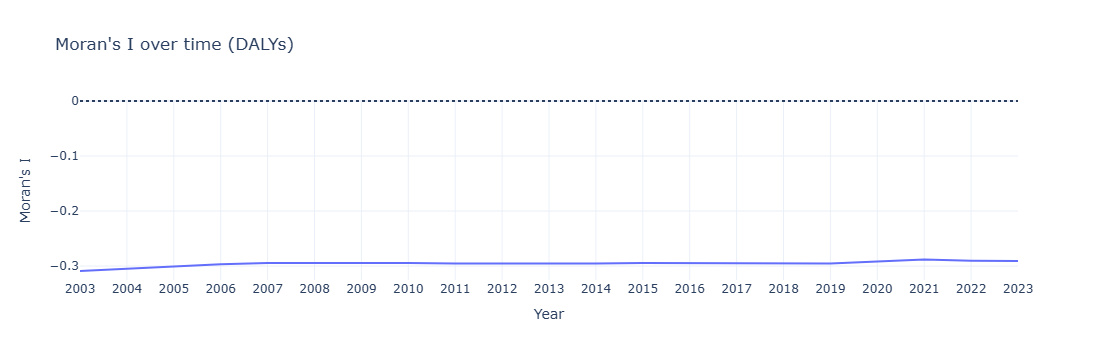

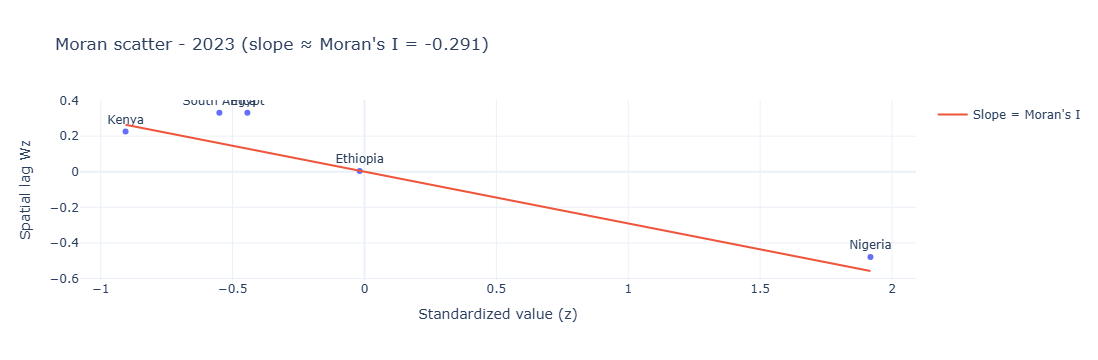

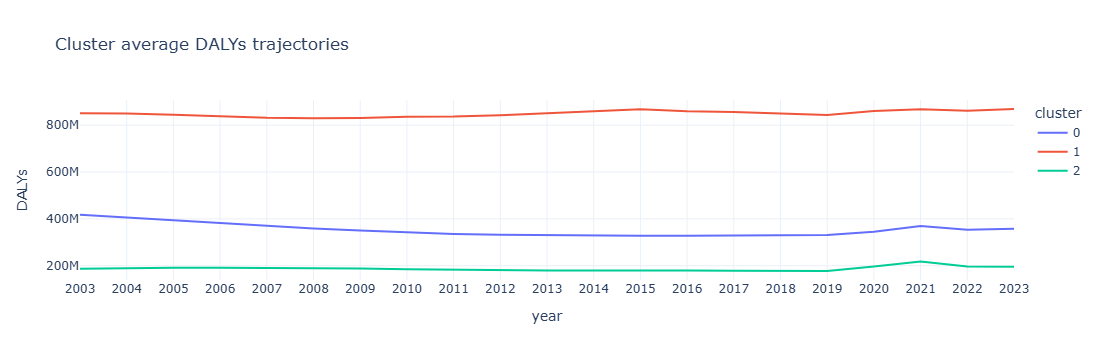

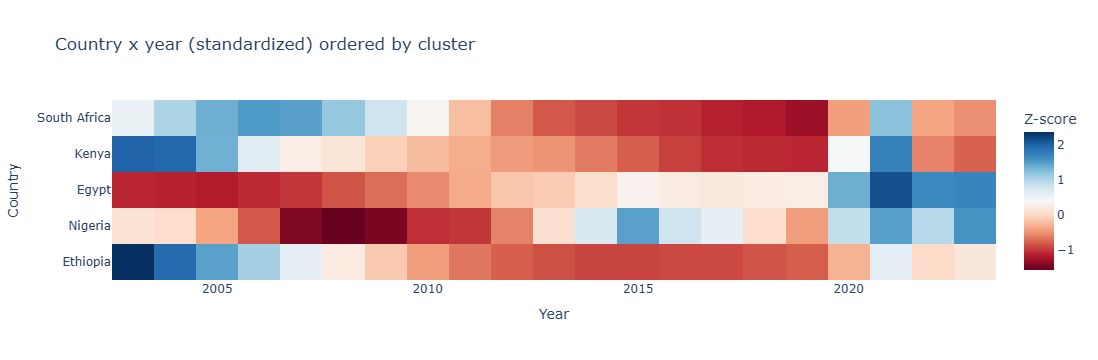

In [86]:
# 14. SPATIAL AUTOCORRELATION AND CLUSTERING
# ------------------------------------------
# Goal:
# - Check whether countries with high DALYs are near each other (Moran's I).
# - Build simple spatial weights using nearest neighbours.
# - Cluster countries based on their full DALY trajectories.

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
import warnings

os.environ["OMP_NUM_THREADS"] = "1"

# Suppress noisy but harmless warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


df = simple_df_total.copy()
METRIC = "val_DALYs"

# restrict to countries with coordinates
centroid = {
    "Ethiopia": (9.145, 40.489),
    "Kenya": (-0.0236, 37.906),
    "Tanzania": (-6.3690, 34.888),
    "Uganda": (1.3733, 32.290),
    "Rwanda": (-1.9403, 29.873),
    "Nigeria": (9.0820, 8.6753),
    "DRC": (-4.0383, 21.7587),
    "South Africa": (-30.5595, 22.9375),
    "Egypt": (26.8206, 30.8025),
    "Ghana": (7.9465, -1.0232),
}

df = df[df["location"].isin(centroid.keys())].copy()
countries = sorted(df["location"].unique())
coords = np.array([centroid[c] for c in countries])

# 14.1 - Build spatial weight matrix W using k nearest neighbours
k = 3
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm="ball_tree").fit(coords)
dist, idx = nbrs.kneighbors(coords)

N = len(countries)
W = np.zeros((N, N))
for i in range(N):
    neighbors = idx[i, 1:]
    for j_idx in neighbors:
        W[i, j_idx] = 1.0

W = np.maximum(W, W.T)
row_sums = W.sum(axis=1, keepdims=True)
W = np.divide(W, row_sums, out=np.zeros_like(W), where=row_sums!=0)

# 14.2 - Moran's I over time
def morans_I(y, W):
    y = np.asarray(y, dtype=float)
    x = y - y.mean()
    S0 = W.sum()
    num = x @ W @ x
    den = x @ x
    N = len(y)
    return (N / S0) * (num / den)

def moran_p_value(y, W, R=999, seed=42):
    rng = np.random.default_rng(seed)
    I_obs = morans_I(y, W)
    perms = np.array([morans_I(rng.permutation(y), W) for _ in range(R)])
    p = (np.sum(np.abs(perms) >= np.abs(I_obs)) + 1) / (R + 1)
    return I_obs, p

moran_rows = []
for yr in sorted(df["year"].unique()):
    ydf = df[df["year"] == yr].set_index("location").reindex(countries)
    y = ydf[METRIC].values
    if np.any(np.isnan(y)):
        continue
    I, p = moran_p_value(y, W, R=999)
    moran_rows.append({"year": int(yr), "I": I, "p_value": p})

moran_df = pd.DataFrame(moran_rows)

fig = px.line(
    moran_df, x="year", y="I",
    title=f"Moran's I over time ({'DALYs' if METRIC=='val_DALYs' else 'Deaths'})",
    labels={"I": "Moran's I", "year": "Year"}
)
fig.add_hline(y=0, line_dash="dot")
fig.update_layout(template="plotly_white", hovermode="x unified")
fig.update_xaxes(dtick=1)
fig.show()

# 14.3 - Moran scatter for latest year
latest = int(moran_df["year"].max())
ydf = df[df["year"] == latest].set_index("location").reindex(countries)
y = ydf[METRIC].values
z = (y - y.mean()) / y.std(ddof=0)
Wz = W @ z
slope = morans_I(y, W)

fig = px.scatter(
    x=z, y=Wz, text=countries,
    title=f"Moran scatter - {latest} (slope ≈ Moran's I = {slope:.3f})",
    labels={"x": "Standardized value (z)", "y": "Spatial lag Wz"}
)
fig.update_traces(mode="markers+text", textposition="top center")
xline = np.linspace(z.min(), z.max(), 100)
fig.add_trace(go.Scatter(x=xline, y=slope*xline, mode="lines", name="Slope = Moran's I"))
fig.update_layout(template="plotly_white")
fig.show()

# 14.4 - KMeans clustering on standardized trajectories
panel = df.pivot_table(index="location", columns="year", values=METRIC, aggfunc="sum")
panel = panel.reindex(index=countries).sort_index(axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(
    panel.fillna(method="ffill", axis=1).fillna(method="bfill", axis=1)
)

k_clusters = 3
kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=20)
labels = kmeans.fit_predict(X)
cluster_df = pd.DataFrame({"location": panel.index, "cluster": labels})
cluster_map = df.merge(cluster_df, on="location", how="left")

# cluster trajectories
mean_traj = cluster_map.groupby(["cluster","year"], as_index=False)[METRIC].mean()

fig = px.line(
    mean_traj, x="year", y=METRIC, color="cluster",
    title=f"Cluster average {('DALYs' if METRIC=='val_DALYs' else 'Deaths')} trajectories",
    labels={METRIC: ("DALYs" if METRIC=="val_DALYs" else "Deaths")}
)
fig.update_layout(template="plotly_white", hovermode="x unified")
fig.update_xaxes(dtick=1)
fig.show()

# heatmap of standardized trajectories ordered by cluster
panel_ordered = panel.copy()
panel_ordered["cluster"] = labels
panel_ordered = panel_ordered.sort_values("cluster")
heat = panel_ordered.drop(columns="cluster")

fig = px.imshow(
    (heat - heat.mean(axis=1).values[:,None]) / heat.std(axis=1).values[:,None],
    labels=dict(x="Year", y="Country", color="Z-score"),
    x=heat.columns, y=heat.index,
    color_continuous_scale="RdBu",
    origin="lower",
    title="Country x year (standardized) ordered by cluster"
)
fig.update_layout(template="plotly_white")
fig.show()

### 15. FEATURE ENGINEERING

In [21]:
df2 = simple_df_total.copy()

# ensure year is numeric
df2["year"] = pd.to_numeric(df["year"], errors="coerce")

df2 = df2.sort_values(["location", "year"])
df2.head()

measure  year location     val_DALYs    val_Deaths
0        2003    Egypt  1.786663e+08  3.522908e+06
1        2004    Egypt  1.781299e+08  3.522390e+06
2        2005    Egypt  1.770487e+08  3.500799e+06
3        2006    Egypt  1.791571e+08  3.563278e+06
4        2007    Egypt  1.808550e+08  3.608550e+06

In [22]:
def create_features(sub):
    sub = sub.copy()
    sub = sub.sort_values("year")

    # --- LAG FEATURES (memory of past values) ---
    for lag in [1, 2, 3]:
        sub[f"DALYs_lag{lag}"] = sub["val_DALYs"].shift(lag)
        sub[f"Deaths_lag{lag}"] = sub["val_Deaths"].shift(lag)

    # --- ROLLING WINDOW STATS (trend + stability) ---
    for window in [2, 3, 5]:
        sub[f"DALYs_rollmean{window}"] = sub["val_DALYs"].rolling(window).mean()
        sub[f"DALYs_rollstd{window}"] = sub["val_DALYs"].rolling(window).std()

        sub[f"Deaths_rollmean{window}"] = sub["val_Deaths"].rolling(window).mean()
        sub[f"Deaths_rollstd{window}"] = sub["val_Deaths"].rolling(window).std()

    # --- GROWTH RATE (momentum) ---
    sub["DALYs_growth"] = sub["val_DALYs"].pct_change()
    sub["Deaths_growth"] = sub["val_Deaths"].pct_change()

    # --- YEARLY DIFFERENCE (delta) ---
    sub["DALYs_diff"] = sub["val_DALYs"].diff()
    sub["Deaths_diff"] = sub["val_Deaths"].diff()

    # --- BURDEN SEVERITY ---
    sub["DALYs_per_death"] = sub["val_DALYs"] / sub["val_Deaths"]

    # --- NORMALIZATION per country (Z-score) ---
    sub["DALYs_norm"] = (sub["val_DALYs"] - sub["val_DALYs"].mean()) / sub["val_DALYs"].std()
    sub["Deaths_norm"] = (sub["val_Deaths"] - sub["val_Deaths"].mean()) / sub["val_Deaths"].std()

    return sub

In [23]:
engineered_list = []

for country in df2["location"].unique():
    sub = df2[df2["location"] == country]
    engineered_list.append(create_features(sub))

df_features = pd.concat(engineered_list, ignore_index=True).dropna()
df_features.head()

measure  year location     val_DALYs    val_Deaths    DALYs_lag1  \
4        2007    Egypt  1.808550e+08  3.608550e+06  1.791571e+08   
5        2008    Egypt  1.844945e+08  3.696030e+06  1.808550e+08   
6        2009    Egypt  1.881875e+08  3.786424e+06  1.844945e+08   
7        2010    Egypt  1.920296e+08  3.863431e+06  1.881875e+08   
8        2011    Egypt  1.964626e+08  3.947412e+06  1.920296e+08   

measure   Deaths_lag1    DALYs_lag2   Deaths_lag2    DALYs_lag3   Deaths_lag3  \
4        3.563278e+06  1.770487e+08  3.500799e+06  1.781299e+08  3.522390e+06   
5        3.608550e+06  1.791571e+08  3.563278e+06  1.770487e+08  3.500799e+06   
6        3.696030e+06  1.808550e+08  3.608550e+06  1.791571e+08  3.563278e+06   
7        3.786424e+06  1.844945e+08  3.696030e+06  1.808550e+08  3.608550e+06   
8        3.863431e+06  1.881875e+08  3.786424e+06  1.844945e+08  3.696030e+06   

measure  ...  DALYs_rollstd5  Deaths_rollmean5  Deaths_rollstd5  DALYs_growth  \
4        ...    1.403617e+06      3.543585e+06     42765.586382      0.009477   
5        ...    2.908157e+06      3.578209e+06     77674.265691      0.020124   
6        ...    4.427285e+06      3.631016e+06    112280.928067      0.020017   
7        ...    5.271051e+06      3.703543e+06    123680.913479      0.020416   
8        ...    6.131958e+06      3.780369e+06    133673.427811      0.023085   

measure  Deaths_growth    DALYs_diff   Deaths_diff  DALYs_per_death  \
4             0.012705  1.697949e+06  45271.440859        50.118478   
5             0.024242  3.639440e+06  87479.997166        49.916931   
6             0.024457  3.693058e+06  90394.610761        49.700589   
7             0.020338  3.842038e+06  77006.740220        49.704409   
8             0.021737  4.433013e+06  83981.002472        49.769967   

measure  DALYs_norm  Deaths_norm  
4         -1.001386    -0.908598  
5         -0.848931    -0.784784  
6         -0.694231    -0.656846  
7         -0.533289    -0.547855  
8         -0.347592    -0.428994  

[5 rows x 29 columns]

### 16. GLOBAL ML MODELS & COMPARISON

### Random Forest, XGBoost, SVR, KNN

In [41]:
import pandas as pd
import numpy as np

# 1) Start from your aggregated panel
df_base = simple_df_total.copy()

# Ensure numeric types
df_base["year"] = pd.to_numeric(df_base["year"], errors="coerce")
df_base["val_DALYs"] = pd.to_numeric(df_base["val_DALYs"], errors="coerce")
df_base["val_Deaths"] = pd.to_numeric(df_base["val_Deaths"], errors="coerce")

df_base = df_base.dropna(subset=["year", "val_DALYs", "val_Deaths"])
df_base = df_base.sort_values(["location", "year"]).reset_index(drop=True)


def make_features(sub):
    """
    Simple, strong feature set for time series regression.
    - Uses lags 1-3
    - 3-year rolling mean
    - yearly differences
    - DALYs per death
    """
    sub = sub.copy().sort_values("year")

    # Lags (memory of last 3 years)
    for lag in [1, 2, 3]:
        sub[f"DALYs_lag{lag}"] = sub["val_DALYs"].shift(lag)
        sub[f"Deaths_lag{lag}"] = sub["val_Deaths"].shift(lag)

    # Rolling means (smooth trend, 3 years)
    sub["DALYs_rollmean3"] = sub["val_DALYs"].rolling(window=3).mean()
    sub["Deaths_rollmean3"] = sub["val_Deaths"].rolling(window=3).mean()

    # Yearly change
    sub["DALYs_diff"] = sub["val_DALYs"].diff()
    sub["Deaths_diff"] = sub["val_Deaths"].diff()

    # Burden per death (severity)
    sub["DALYs_per_death"] = sub["val_DALYs"] / sub["val_Deaths"]

    return sub


# Apply per country
engineered = []
for c in df_base["location"].unique():
    sub = df_base[df_base["location"] == c]
    engineered.append(make_features(sub))

df_fe = pd.concat(engineered, ignore_index=True)

print("Feature engineered shape before dropping NaN:", df_fe.shape)
df_fe.head()


Feature engineered shape before dropping NaN: (105, 15)


measure  year location     val_DALYs    val_Deaths    DALYs_lag1  \
0        2003    Egypt  1.786663e+08  3.522908e+06           NaN   
1        2004    Egypt  1.781299e+08  3.522390e+06  1.786663e+08   
2        2005    Egypt  1.770487e+08  3.500799e+06  1.781299e+08   
3        2006    Egypt  1.791571e+08  3.563278e+06  1.770487e+08   
4        2007    Egypt  1.808550e+08  3.608550e+06  1.791571e+08   

measure   Deaths_lag1    DALYs_lag2   Deaths_lag2    DALYs_lag3   Deaths_lag3  \
0                 NaN           NaN           NaN           NaN           NaN   
1        3.522908e+06           NaN           NaN           NaN           NaN   
2        3.522390e+06  1.786663e+08  3.522908e+06           NaN           NaN   
3        3.500799e+06  1.781299e+08  3.522390e+06  1.786663e+08  3.522908e+06   
4        3.563278e+06  1.770487e+08  3.500799e+06  1.781299e+08  3.522390e+06   

measure  DALYs_rollmean3  Deaths_rollmean3    DALYs_diff   Deaths_diff  \
0                    NaN               NaN           NaN           NaN   
1                    NaN               NaN -5.363735e+05   -517.918171   
2           1.779483e+08      3.515366e+06 -1.081258e+06 -21591.027983   
3           1.781119e+08      3.528823e+06  2.108405e+06  62478.878917   
4           1.790203e+08      3.557542e+06  1.697949e+06  45271.440859   

measure  DALYs_per_death  
0              50.715567  
1              50.570749  
2              50.573782  
3              50.278720  
4              50.118478

In [42]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows where features are not available (first 3 years per country)
df_ml = df_fe.dropna(subset=[
    "val_DALYs", "val_Deaths",
    "DALYs_lag1", "DALYs_lag2", "DALYs_lag3",
    "Deaths_lag1", "Deaths_lag2", "Deaths_lag3",
    "DALYs_rollmean3", "Deaths_rollmean3",
    "DALYs_diff", "Deaths_diff",
    "DALYs_per_death"
]).reset_index(drop=True)

# Encode country
le = LabelEncoder()
df_ml["location_code"] = le.fit_transform(df_ml["location"])

# Year numeric feature
df_ml["year_num"] = df_ml["year"].astype(int)

TARGET = "val_DALYs"

# Choose features (no uncertainty bounds, no growth, no norm)
feature_cols = [
    "val_Deaths",
    "DALYs_lag1", "DALYs_lag2", "DALYs_lag3",
    "Deaths_lag1", "Deaths_lag2", "Deaths_lag3",
    "DALYs_rollmean3", "Deaths_rollmean3",
    "DALYs_diff", "Deaths_diff",
    "DALYs_per_death",
    "location_code", "year_num"
]

X = df_ml[feature_cols]
y = df_ml[TARGET]

print("Final modeling dataset shape:", X.shape)
print("Feature columns:", feature_cols)

Final modeling dataset shape: (90, 14)
Feature columns: ['val_Deaths', 'DALYs_lag1', 'DALYs_lag2', 'DALYs_lag3', 'Deaths_lag1', 'Deaths_lag2', 'Deaths_lag3', 'DALYs_rollmean3', 'Deaths_rollmean3', 'DALYs_diff', 'Deaths_diff', 'DALYs_per_death', 'location_code', 'year_num']


In [43]:
# Sort by year to get unique sorted years
years_sorted = sorted(df_ml["year"].unique())
n_years = len(years_sorted)
cut = int(n_years * 0.8)

train_years = years_sorted[:cut]
test_years = years_sorted[cut:]

print("Train years:", train_years)
print("Test years:", test_years)

mask_train = df_ml["year"].isin(train_years)
mask_test = df_ml["year"].isin(test_years)

X_train_raw, X_test_raw = X[mask_train], X[mask_test]
y_train, y_test = y[mask_train], y[mask_test]

print("Train size:", X_train_raw.shape, "Test size:", X_test_raw.shape)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

Train years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
Test years: [2020, 2021, 2022, 2023]
Train size: (70, 14) Test size: (20, 14)


In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("XGBoost Performance - Clean Feature Set")
print("---------------------------------------")
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"R²:   {r2:.4f}")

XGBoost Performance - Clean Feature Set
---------------------------------------
MAE:  24,071,965
RMSE: 35,242,764
R²:   0.9816


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

def eval_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "MAE": mean_absolute_error(y_test, pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, pred)),
        "R2": r2_score(y_test, pred)
    }

results = {}
results["XGBoost"] = {"MAE": mae, "RMSE": rmse, "R2": r2}

results["RandomForest"] = eval_model(
    RandomForestRegressor(n_estimators=600, max_depth=10, random_state=42)
)

results["SVR"] = eval_model(
    SVR(kernel="rbf", C=10, gamma=0.1)
)

results["KNN"] = eval_model(
    KNeighborsRegressor(n_neighbors=5)
)

pd.DataFrame(results).T

MAE          RMSE        R2
XGBoost       3.201402e+07  4.445371e+07  0.970785
RandomForest  1.266362e+07  1.627480e+07  0.996084
SVR           1.857231e+08  3.017628e+08 -0.346252
KNN           6.688102e+07  7.811585e+07  0.909786

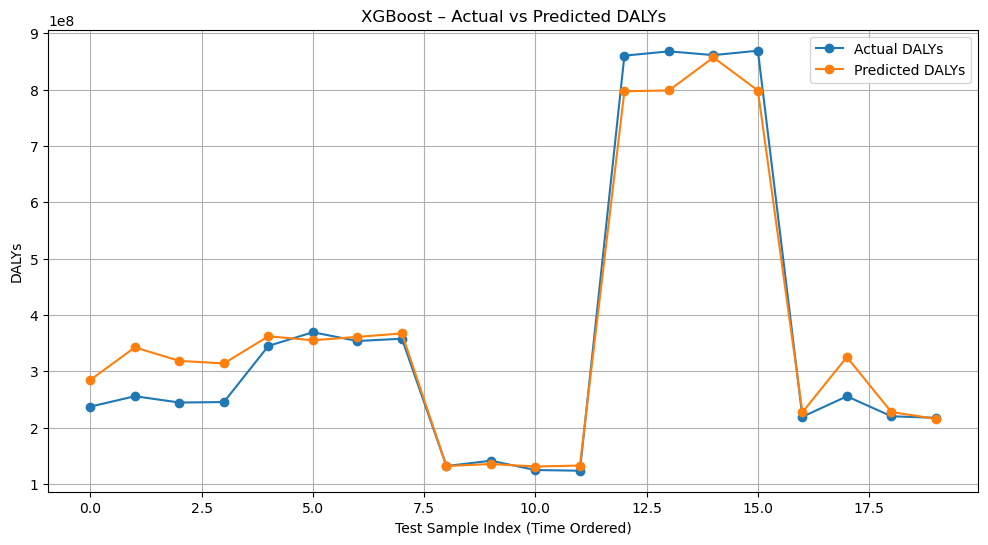

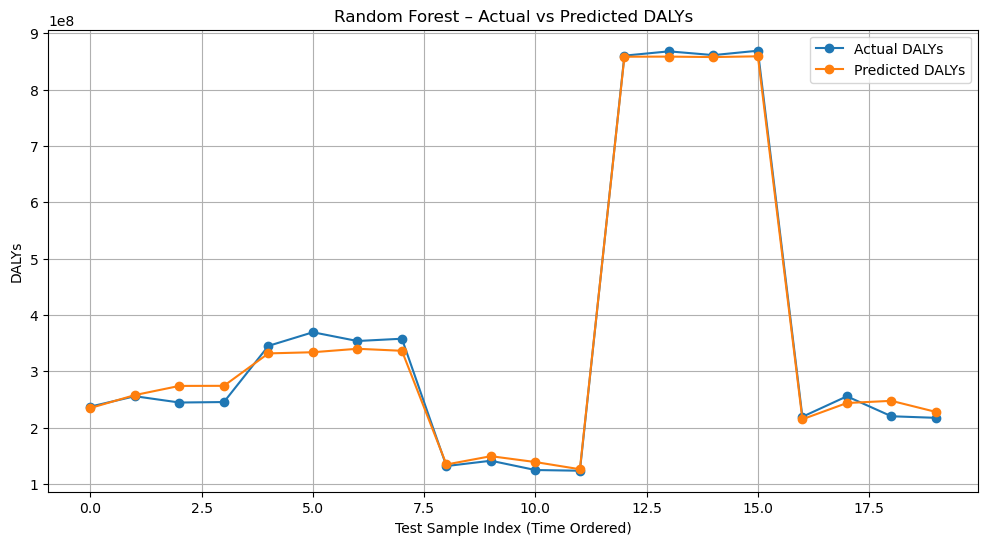

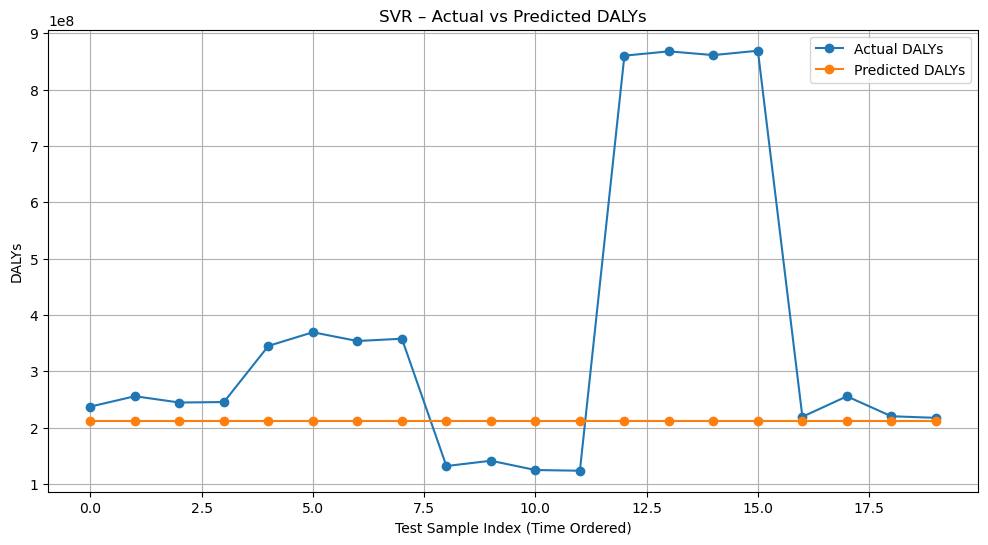

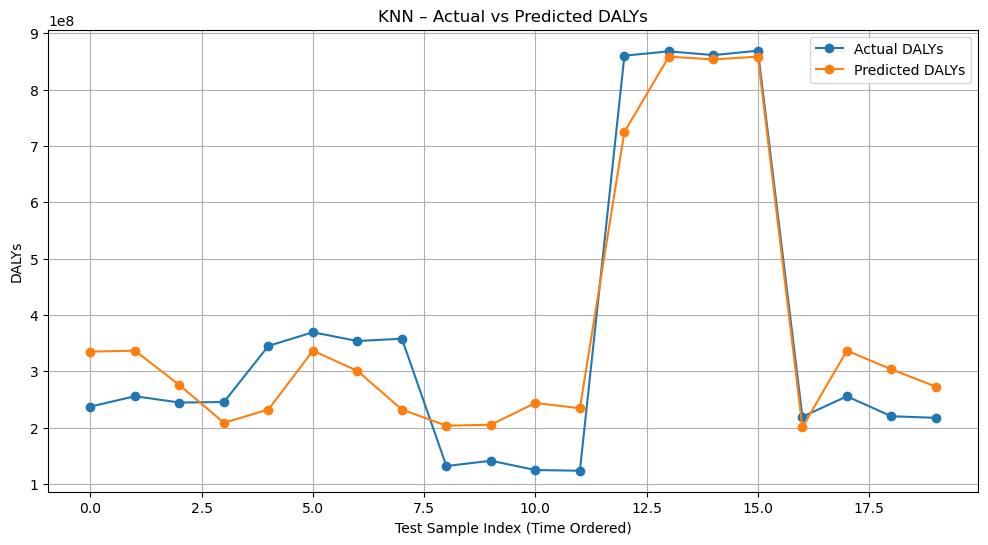

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 1) Make predictions for each model ---

# XGBoost predictions were already computed earlier as y_pred
pred_xgb = y_pred

# Random Forest
rf = RandomForestRegressor(n_estimators=600, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# SVR
svr = SVR(kernel="rbf", C=10, gamma=0.1)
svr.fit(X_train, y_train)
pred_svr = svr.predict(X_test)

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)


# --- 2) Helper function to plot ---
def plot_model(preds, title):
    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label="Actual DALYs", marker="o")
    plt.plot(preds, label="Predicted DALYs", marker="o")
    plt.title(title)
    plt.xlabel("Test Sample Index (Time Ordered)")
    plt.ylabel("DALYs")
    plt.legend()
    plt.grid(True)
    plt.show()


# --- 3) Produce plots for each model ---
plot_model(pred_xgb, "XGBoost – Actual vs Predicted DALYs")
plot_model(pred_rf, "Random Forest – Actual vs Predicted DALYs")
plot_model(pred_svr, "SVR – Actual vs Predicted DALYs")
plot_model(pred_knn, "KNN – Actual vs Predicted DALYs")